In [ ]:
"""
author: EdgardoCS @FSU Jena
date: 16.04.2025
"""

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

pd.options.mode.chained_assignment = None

In [1]:
#TODO: change name knee to Leg, store it as Legs, the same for anything that is plural. Check values for legs (knee), I get that is for means, check for median values

In [2]:
input_data = "output/data_sorted.xlsx"
columns = ['id', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])

# Conditions:
# front + Self + Female
# front + Self + Male
# front + Other + Female
# front + Other + Male
#
# back + Self + Female
# back + Self + Male
# back + Other + Female
# back + Other + Male

In [163]:
# Factor	Levels	            Type
# Gender	Male, Female	    Between-subjects
# Type	    Self, Other	        Within-subjects (each participant rated both)
# Location	Front, Back	        Within-subjects
# Segment	9 regions           Within-subjects

# Dependent variable
#   Points in image (smell rating)
# Independent variables / Fixed effects
#   Gender
#   Type
#   Location
#   Segment
# Random effect
#   Subject

In [164]:
# data['Gender'] = data['Gender'].asType('category')
# data['Segment'] = data['Segment'].asType('category')
# data['Location'] = data['Location'].asType('category')
# data['Type'] = data['Type'].asType('category')
# data['id'] = data['id'].asType('category')  # Random effect

In [3]:
female = data[data['Gender'] == 'Female'].copy()
male = data[data['Gender'] == 'Male'].copy()
col_order = ["Armpit", "Chest", "Feet", "Hair", "Hand", "Knee", "Mouth", "Neck", "Pelvis"]

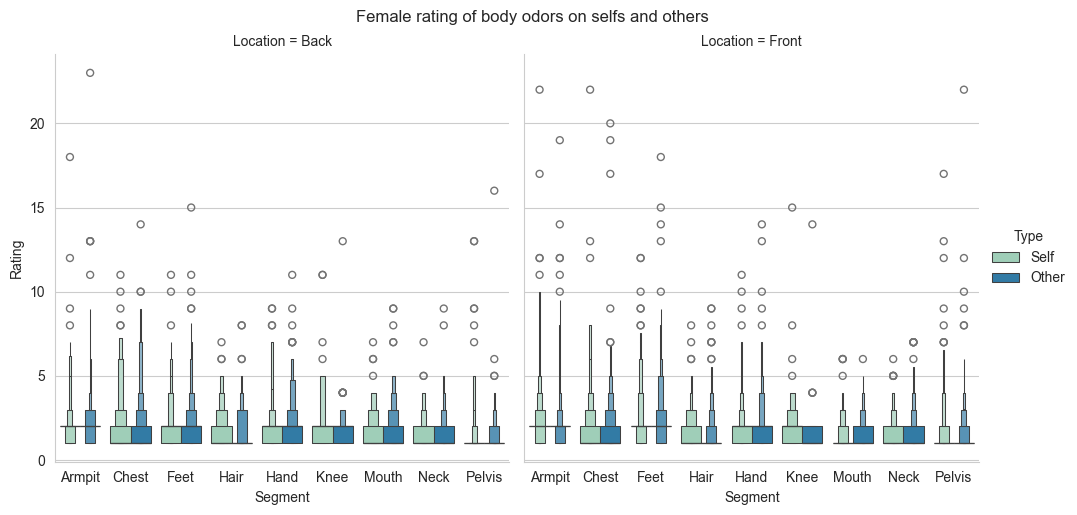

In [166]:
sns.catplot(
    data=female,
    kind='boxen',
    x='Segment',
    y='Rating',
    hue='Type',
    palette='YlGnBu',
    col='Location',
    col_wrap=2,
    order=col_order

    # showfliers=False
)
# plt.tight_layout()
plt.suptitle('Female rating of body odors on selfs and others', y=1.02)
plt.savefig('output/stats/female.boxen.png', bbox_inches='tight', dpi=300)

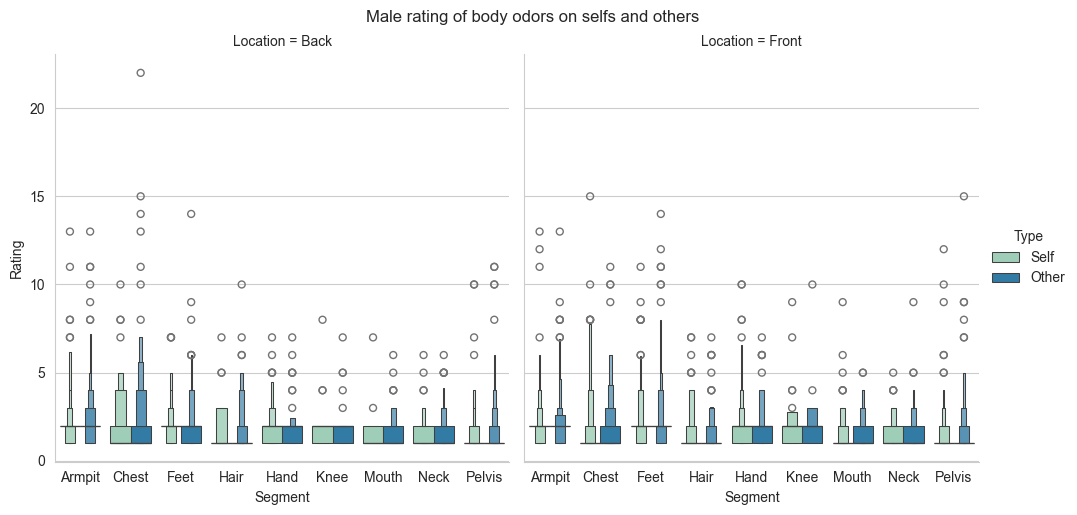

In [167]:
sns.catplot(
    data=male,
    kind='boxen',
    x='Segment',
    y='Rating',
    hue='Type',
    palette='YlGnBu',
    col='Location',
    col_wrap=2,
    order=col_order
    # showfliers=False
)
# plt.tight_layout()
plt.suptitle('Male rating of body odors on selfs and others', y=1.02)
plt.savefig('output/stats/male.boxen.png', bbox_inches='tight', dpi=300)

In [168]:

model = smf.mixedlm(
    "Rating ~ Segment * Location * Type * Gender",
    data,
    groups=data["id"]
)
result = model.fit()
print(result.summary())

# Reference: Female, Others, armpit
# Intercept 2,004, p = 0,000 (***)

# Location (front) 0,032, p 0,466 (ns)
# Type (Self) -0,004, p = 0,941 (ns)
# Gender (Male) 0,082, p = 0,207 (ns)
# β, p
# Segment[T.chest] -0.266, p = 0.000 (***)
# Segment[T.feet] -0.034, p = 0.518 (ns)
# Segment[T.hair] -0.670, p = 0.000 (***)
# Segment[T.hand] -0.298, p = 0.000 (***)
# Segment[T.knee] -0.367, p = 0.000 (***)
# Segment[T.mouth] -0.583, p = 0.000 (***)
# Segment[T.neck] -0.637, p = 0.000 (***)
# Segment[T.pelvis] -0.802, p = 0.000 (***)

# Compared to the highest rated Segment, armpit, the Others were rated significantly lower with the exception of the feet.
# chest is rated higher in the back (β = -0.207, p = 0.016), as well as knee (β = -0.335, p = 0.017)
# feet are rated higher in the front (β = 0.178, p = 0.007), as well as neck (β = 0.156, p = 0.027)
# No significant three- or four-way interactions involving Type (p = 0,941) or Gender (p = 0,207) were observed.


                                   Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 Rating     
No. Observations:                   26915                   Method:                             REML       
No. Groups:                         2409                    Scale:                              0.9005     
Min. group size:                    1                       Log-Likelihood:                     -39005.2520
Max. group size:                    36                      Converged:                          Yes        
Mean group size:                    11.2                                                                   
-----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------

In [169]:
# 1. Is there any difference between Female and Male when smelling Others?
target = (data[
              (data['Type'] == 'Other') &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
three_model = ols("""Rating ~ C(Segment) + C(Gender) + C(Location) +
               C(Segment):C(Gender) + C(Segment):C(Location) + C(Gender):C(Location) +
               C(Segment):C(Gender):C(Location)""", data=target).fit()
res1 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Gender) -> p= 0,884
# C(Location) -> p= 0,366
# C(Segment):C(Gender) -> p= 0,355
# C(Segment):C(Location) -> p= 7,385
# C(Gender):C(Location) -> p= 0,224
# C(Segment):C(Gender):C(Location) -> p= 0,495

# Answer, apparently *None* given the three model calculation

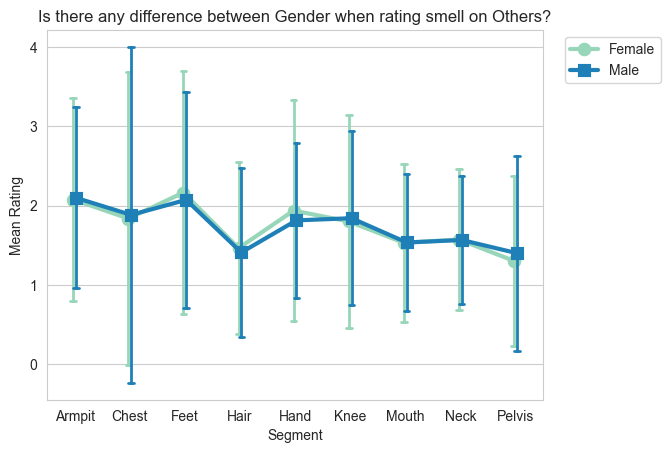

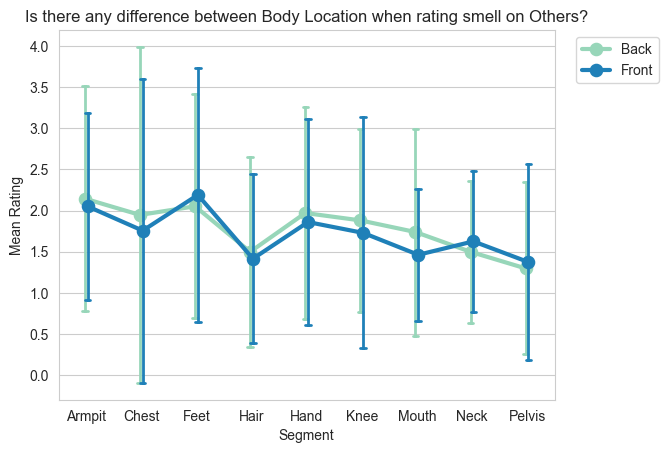

In [170]:
# Plot interaction between Segment and Gender
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Gender',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Gender when rating smell on Others?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
plt.show()

# Plot interaction between Segment and Location
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Location',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Body Location when rating smell on Others?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
plt.show()

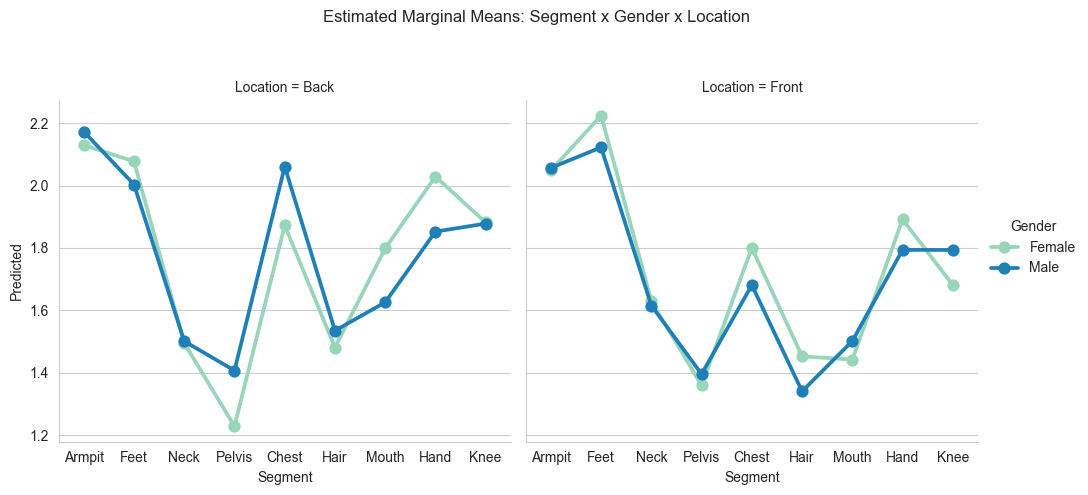

In [171]:
# Create a grid of all combinations
combinations = pd.DataFrame([
    (seg, gen, loc)
    for seg in target['Segment'].unique()
    for gen in target['Gender'].unique()
    for loc in target['Location'].unique()
], columns=['Segment', 'Gender', 'Location'])

# Predict marginal means
combinations['Predicted'] = three_model.predict(combinations)

# Plot 3-way interaction
sns.catplot(
    data=combinations,
    x='Segment',
    y='Predicted',
    hue='Gender',
    col='Location',
    kind='point',
    palette='YlGnBu',
    errorbar=None
)
plt.subplots_adjust(top=0.8)
plt.suptitle('Estimated Marginal Means: Segment x Gender x Location')
plt.show()

In [172]:
# 2. Is there any difference between Female and Male when smelling themselves?
target = (data[
              (data['Type'] == 'Self') &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
three_model = ols("""Rating ~ C(Segment) + C(Gender) + C(Location) +
               C(Segment):C(Gender) + C(Segment):C(Location) + C(Gender):C(Location) +
               C(Segment):C(Gender):C(Location)""", data=target).fit()
res2 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Gender) -> p= 0,009
# C(Location) -> p= 0,152
# C(Segment):C(Gender) -> p= 0,977
# C(Segment):C(Location) -> p= 0,022
# C(Gender):C(Location) -> p= 0,668
# C(Segment):C(Gender):C(Location) -> p= 0,816

# Answer, there is a main effect of Gender, and there is significant difference
# between Segment and Location when participants smell themselves

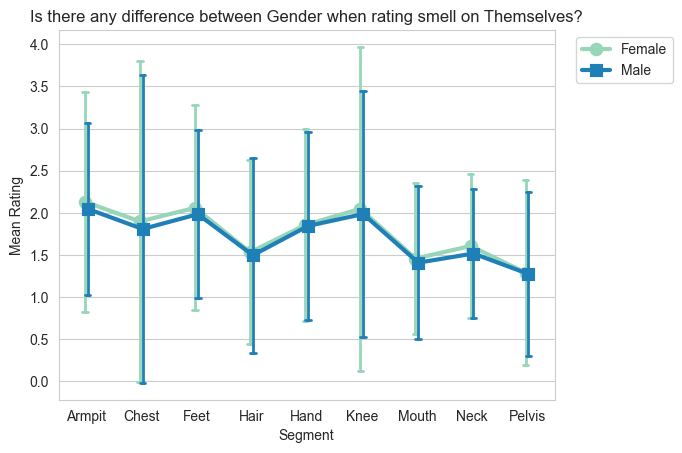

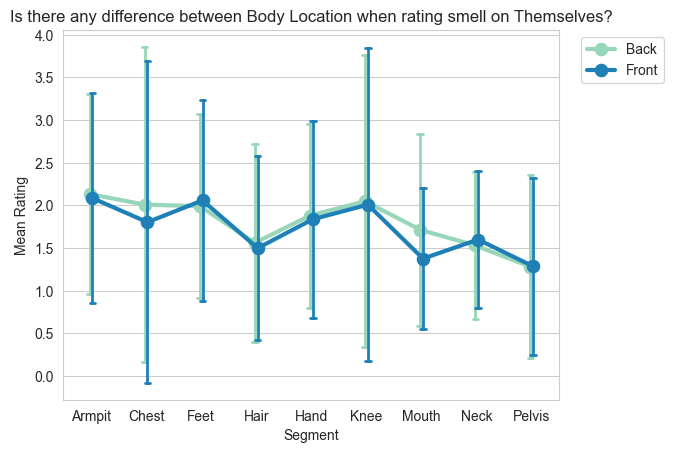

In [173]:
# Plot interaction between Segment and Gender
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Gender',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Gender when rating smell on Themselves?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-self-gender.png', bbox_inches='tight', dpi=300)
plt.show()
# Plot interaction between Segment and Location
sns.pointplot(
    data=target,
    x='Segment',
    y='Rating',
    hue='Location',
    errorbar='sd',
    dodge=True,
    capsize=.1,
    palette='YlGnBu',
    order=col_order,
    linewidth=3,
    err_kws={'linewidth': 2},
)
plt.title('Is there any difference between Body Location when rating smell on Themselves?')
plt.ylabel('Mean Rating')
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/stats/pointplot-self-location.png', bbox_inches='tight', dpi=300)
plt.show()

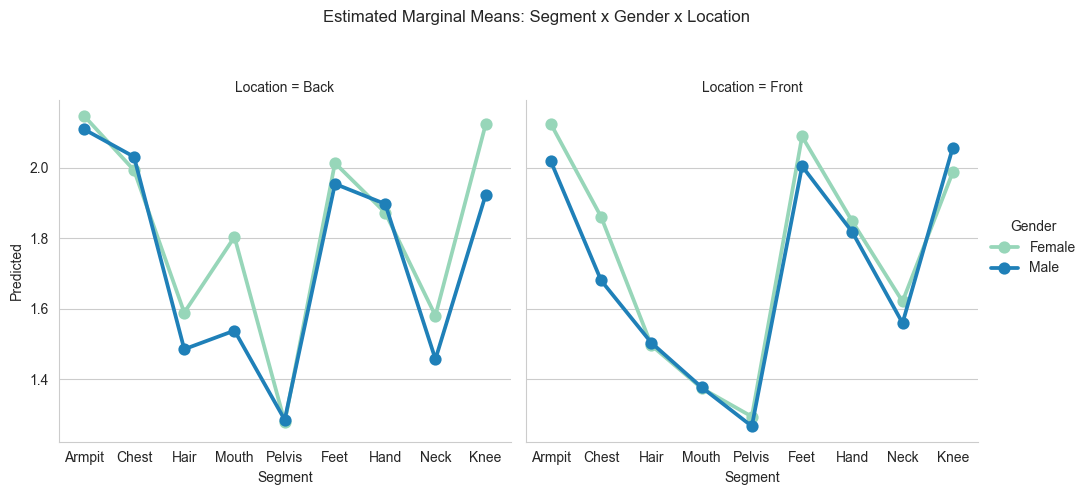

In [174]:
# Create a grid of all combinations
combinations = pd.DataFrame([
    (seg, gen, loc)
    for seg in target['Segment'].unique()
    for gen in target['Gender'].unique()
    for loc in target['Location'].unique()
], columns=['Segment', 'Gender', 'Location'])

# Predict marginal means
combinations['Predicted'] = three_model.predict(combinations)

# Plot 3-way interaction
sns.catplot(
    data=combinations,
    x='Segment',
    y='Predicted',
    hue='Gender',
    col='Location',
    kind='point',
    palette='YlGnBu',
    errorbar=None
)
plt.subplots_adjust(top=0.8)
plt.suptitle('Estimated Marginal Means: Segment x Gender x Location')
plt.show()

In [175]:
# target["Segment_Location"] = target["Segment"] + "_" + target["Location"]
# tukey = pairwise_tukeyhsd(target["Rating"], target["Segment_Location"])
# print(tukey)

In [176]:
# Take both Genders, front and back when smelling themselves
target = data[
    (data['Location'].isin(['Front', 'Back'])) &
    (data['Type'] == 'Self') &
    (data['Gender'].isin(['Female', 'Male']))
    ].copy()
target['group1'] = (
        target['Location'] + '_'
        + target['Segment']
)

# target['group2'] = (
#         target['Gender'] + '_'
#         + target['Segment']
# )
# target['group3'] = (
#         target['Gender'] + '_'
#         + target['Location'] + '_'
#         + target['Segment']
# )

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group1'], alpha=0.05)

# group     meandiff	p-adj	lower	upper	reject
# (front vs back)
# armpit	-0.0481	    0.9999	-0.2054	0.1093	False
# chest	    -0.2054	    0.7353	-0.5271	0.1163	False
# feet	    0.0671	    0.9986	-0.1164	0.2506	False
# hair	    -0.0627	    1.0	    -0.3866	0.2612	False
# hand	    -0.0428	    1.0	    -0.281	0.1954	False
# knee	    -0.0394	    1.0	    -0.597	0.5182	False
# mouth	    -0.3381	    0.1214	-0.7076	0.0314	False
# neck	    0.0695	    1.0	    -0.224	0.3629	False
# pelvis	0.0039	    1.0	    -0.1752	0.1831	False

# group     meandiff	p-adj	lower	upper	reject
# (Female vs Male)
# armpit	-0.084	    0.9009	-0.236	0.0679	False
# chest	    -0.0897	    0.9999	-0.4026	0.2231	False
# feet	    -0.075	    0.9957	-0.2619	0.1119	False
# hair	    -0.0351	    1.0	    -0.3826	0.3125	False
# hand	    -0.0119	    1.0	    -0.2541	0.2302	False
# knee	    -0.0618	    1.0	    -0.6508	0.5272	False
# mouth	    -0.0487	    1.0	    -0.3572	0.2598	False
# neck	    -0.0892	    0.9999	-0.3832	0.2048	False
# pelvis	    -0.0146	    1.0	    -0.1944	0.1652	False

# When comparing the same Locations, there is no statistically difference between Gender and Location regarding smelling themselves

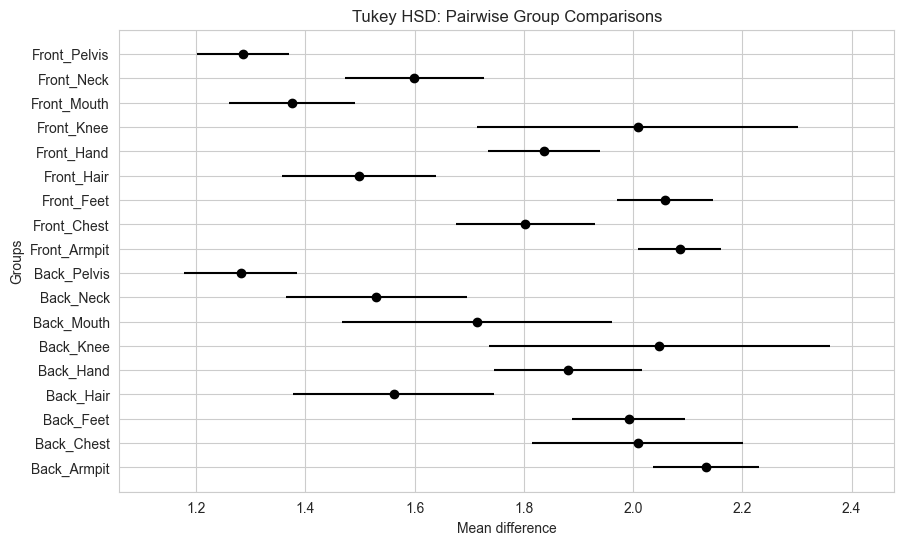

In [177]:
# Plot Tukey's HSD results
tukey.plot_simultaneous(comparison_name=None, xlabel='Mean difference', ylabel='Groups')
plt.title('Tukey HSD: Pairwise Group Comparisons')
plt.show()

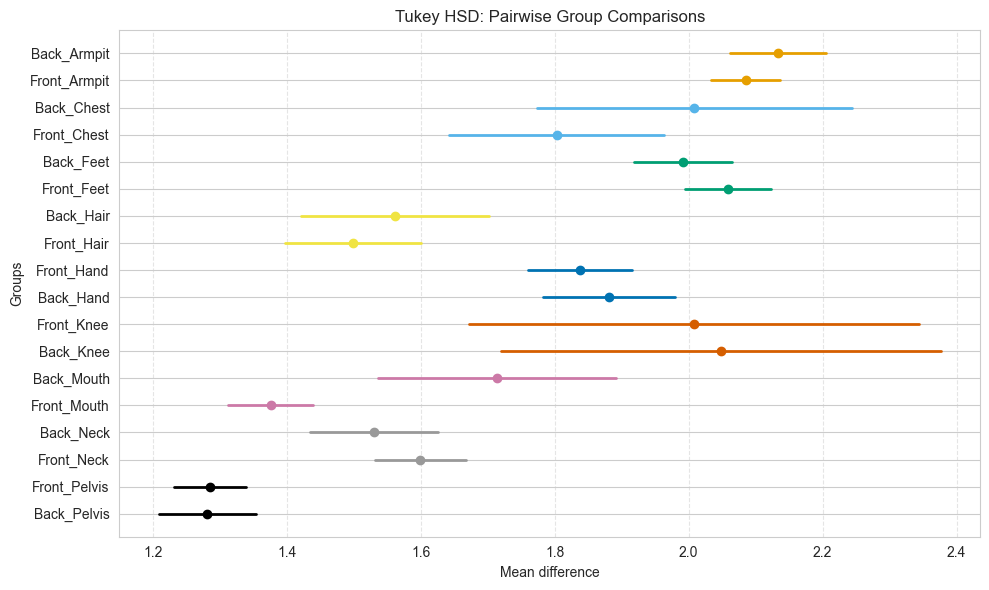

In [178]:
summary = (
    target.groupby('group1')['Rating']
    .agg(['mean', 'count', 'std'])
    .reset_index()
)
summary = summary.sort_values('mean')

summary['ci95'] = 1.96 * (summary['std'] / summary['count'] ** 0.5)
summary['lower'] = summary['mean'] - summary['ci95']
summary['upper'] = summary['mean'] + summary['ci95']

colors = ['#E69F00',  # orange
          '#56B4E9',  # sky blue
          '#009E73',  # bluish green
          '#F0E442',  # yellow
          '#0072B2',  # blue
          '#D55E00',  # vermillion
          '#CC79A7',  # reddish purple
          '#999999',  # gray
          '#000000',  # black
          ]

highlight_groups = [['Front_Armpit', 'Back_Armpit'],
                    ['Front_Chest', 'Back_Chest'],
                    ['Front_Feet', 'Back_Feet'],
                    ['Front_Hair', 'Back_Hair'],
                    ['Front_Hand', 'Back_Hand'],
                    ['Front_Knee', 'Back_Knee'],
                    ['Front_Mouth', 'Back_Mouth'],
                    ['Front_Neck', 'Back_Neck'],
                    ['Front_Pelvis', 'Back_Pelvis']]

summary['sort_key'] = summary['group1'].apply(lambda x: x.split('_')[1] if '_' in x else x)

# Sort rows by that substring
summary = summary.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

group_color_map = {}
for group_pair, color in zip(highlight_groups, colors):
    for g in group_pair:
        group_color_map[g] = color

summary['color'] = summary['group1'].map(group_color_map).fillna('black')

fig, ax = plt.subplots(figsize=(10, 6))

for i, row in enumerate(summary.itertuples()):
    ax.plot([row.lower, row.upper], [i, i], color=row.color, lw=2)
    ax.plot(row.mean, i, 'o', color=row.color)

ax.set_yticks(range(len(summary)))
ax.set_yticklabels(summary['group1'])
ax.invert_yaxis()
ax.set_xlabel('Mean difference')
ax.set_ylabel('Groups')
ax.set_title('Tukey HSD: Pairwise Group Comparisons')

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('output/stats/Tukey-self-locations.png', bbox_inches='tight', dpi=300)
# plt.show()

In [179]:
# 3. is there any difference when Males smell themselves vs when they smell Others?
target = (data[
              (data['Type'].isin(['Self', 'Other'])) &
              (data['Gender'] == 'Male')]
          .copy())
three_model = ols("""Rating ~ C(Segment) + C(Type) + C(Location) +
               C(Segment):C(Type) + C(Segment):C(Location) + C(Type):C(Location) +
               C(Segment):C(Type):C(Location)""", data=target).fit()
res3 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Type) -> p= 0,031
# C(Location) -> p= 0,043
# C(Segment):C(Type) -> p= 0,537
# C(Segment):C(Location) -> p= 0,001
# C(Type):C(Location) -> p= 0,884
# C(Segment):C(Type):C(Location) -> p= 0,984

# Answer, there is a main effect of Type, and there is significant difference
# between Segment and Location when participants smell themselves vs when they smell Others

In [180]:
# Lets check the above
target = data[
    (data['Location'].isin(['Front', 'Back'])) &
    (data['Gender'] == 'Male') &
    (data['Type'].isin(['Self', 'Other']))
    ].copy()
target['group1'] = (
        target['Type'] + '_'
        + target['Segment']
)
target['group2'] = (
        target['Location'] + '_'
        + target['Segment']
)
tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group2'], alpha=0.05)

# group     meandiff	p-adj	lower	upper	reject
# (Self vs Other)
# armpit	-0.0506	    0.9999	-0.217	0.1158	False
# chest	    -0.0745	    1.0	    -0.39	0.2411	False
# feet	    -0.0883	    0.9916	-0.2955	0.1188	False
# hair	    0.0869	    1.0	    -0.2664	0.4402	False
# hand	    0.0305	    1.0	    -0.2601	0.321	False
# knee	    0.1451	    1.0	    -0.4341	0.7243	False
# mouth	    -0.127	    0.997	-0.4533	0.1994	False
# neck	    -0.0494	    1.0	    -0.3232	0.2244	False
# pelvis	-0.1268	    0.7585	-0.3285	0.0749	False

# group     meandiff	p-adj	lower	upper	reject
# (front vs back)
# armpit	-0.1062	    0.8087	-0.2815	0.0691	False
# chest	    -0.3709	    0.0032	-0.6774	-0.0643	True
# feet	    0.0838	    0.9961	-0.1266	0.2942	False
# hair	    -0.1236	    0.999	-0.4705	0.2233	False
# hand	    -0.0699	    1.0	    -0.3747	0.2348	False
# knee	    -0.0048	    1.0	    -0.5552	0.5456	False
# mouth	    -0.1502	    0.9962	-0.5281	0.2277	False
# neck	    0.11	    0.9898	-0.1436	0.3636	False
# pelvis	-0.0228	    1.0	    -0.2266	0.1811	False



C:\Users\silva\Documents\PythonProject\smell-jena\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [181]:
# 4. is there any difference when Females smell themselves vs when they smell Others?
target = (data[
              (data['Type'].isin(['Self', 'Other'])) &
              (data['Gender'] == 'Female')]
          .copy())
three_model = ols("""Rating ~ C(Segment) + C(Type) + C(Location) +
               C(Segment):C(Type) + C(Segment):C(Location) + C(Type):C(Location) +
               C(Segment):C(Type):C(Location)""", data=target).fit()
res4 = anova_lm(three_model, typ=2)

# C(Segment) -> p= 0,000
# C(Type) -> p= 0,955
# C(Location) -> p= 0,569
# C(Segment):C(Type) -> p= 0,043
# C(Segment):C(Location) -> p= 7,251
# C(Type):C(Location) -> p= 0,478
# C(Segment):C(Type):C(Location) -> p= 0,881

In [182]:
# Lets check the above
target = data[
    (data['Location'].isin(['Front', 'Back'])) &
    (data['Gender'] == 'Female') &
    (data['Type'].isin(['Self', 'Other']))
    ].copy()

target['group'] = target['Type'] + '_' + target['Segment']

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['group'], alpha=0.05)

# group     meandiff	p-adj	lower	upper	reject
# (Self vs Other)
# armpit	0.0552	0.9952	-0.0808	0.1912	False
# chest	    0.0606	1.0	    -0.1973	0.3184	False
# feet	    -0.1047	0.7349	-0.2687	0.0593	False
# hair	    0.0679	1.0	    -0.1833	0.3191	False
# hand	    -0.0807	0.9985	-0.3	0.1385	False
# knee	    0.2483	0.9338	-0.2234	0.72	False
# mouth	    -0.3381	0.1214	-0.7076	0.0314	False
# pelvis	0.0039	1.0	    -0.1752	0.1831	False
# neck 	    0.0695	1.0	    -0.224	0.3629	False
# mouth	    -0.0743	0.9999	-0.3243	0.1756	False
# neck 	    0.0341	1.0	    -0.1943	0.2625	False
# pelvis	-0.0141	1.0	    -0.1776	0.1494	False

# None

C:\Users\silva\Documents\PythonProject\smell-jena\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [183]:
# 5. Comparing the body as whole, is there any difference between Female and Males when smelling themselves in front and back, and what about when smelling Others?
target = (data[
              (data['Type'].isin(['Self', 'Other'])) &
              (data['Gender'].isin(['Female', 'Male']))]
          .copy())
three_model = ols("""Rating ~ C(Gender) + C(Type) + C(Location) +
               C(Gender):C(Type) + C(Gender):C(Location) + C(Type):C(Location) +
               C(Gender):C(Type):C(Location)""", data=target).fit()
res5 = anova_lm(three_model, typ=2)
# None


In [184]:
# 6. Where do Females prefer to smell themselves (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Female') &
    (data['Type'] == 'Self')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Armpit  Chest  -0.2632 0.0102 -0.4908 -0.0356   True
Armpit   Feet  -0.0353 0.9993 -0.2045  0.1338  False
Armpit   Hair  -0.6272    0.0 -0.8713 -0.3832   True
Armpit   Hand  -0.2763 0.0003 -0.4674 -0.0851   True
Armpit   Knee  -0.1364 0.9894 -0.5782  0.3054  False
Armpit  Mouth  -0.7486    0.0  -0.961 -0.5363   True
Armpit   Neck  -0.5029    0.0 -0.7347 -0.2711   True
Armpit Pelvis  -0.8291    0.0 -0.9906 -0.6677   True
 Chest   Feet   0.2279 0.0864 -0.0151  0.4708  False
 Chest   Hair   -0.364 0.0053  -0.664 -0.0641   True
 Chest   Hand  -0.0131    1.0 -0.2719  0.2457  False
 Chest   Knee   0.1268  0.996 -0.3482  0.6018  False
 Chest  Mouth  -0.4854    0.0 -0.7602 -0.2106   True
 Chest   Neck  -0.2397  0.202 -0.5298  0.0503  False
 Chest Pelvis  -0.5659    0.0 -0.8036 -0.3283   True
  Feet   Hair  -0.5919    0.0 -0.8503 -0.3335 

In [185]:
# 7. Where do Females prefer to smell Others (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Female') &
    (data['Type'] == 'Other')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Armpit  Chest  -0.2475 0.0372 -0.4875 -0.0075   True
Armpit   Feet   0.1759  0.033  0.0074  0.3443   True
Armpit   Hair  -0.5949    0.0 -0.8036 -0.3862   True
Armpit   Hand  -0.1567 0.3168 -0.3643  0.0509  False
Armpit   Knee  -0.3663 0.1799 -0.8007  0.0681  False
Armpit  Mouth  -0.6053    0.0 -0.8038 -0.4067   True
Armpit   Neck  -0.4176    0.0 -0.6002 -0.2349   True
Armpit Pelvis  -0.6881    0.0  -0.863 -0.5132   True
 Chest   Feet   0.4234    0.0  0.1706  0.6761   True
 Chest   Hair  -0.3474 0.0041 -0.6285 -0.0662   True
 Chest   Hand   0.0908 0.9855 -0.1895  0.3711  False
 Chest   Knee  -0.1188 0.9974 -0.5923  0.3547  False
 Chest  Mouth  -0.3578 0.0017 -0.6315 -0.0841   True
 Chest   Neck  -0.1701 0.5354 -0.4324  0.0923  False
 Chest Pelvis  -0.4406    0.0 -0.6976 -0.1835   True
  Feet   Hair  -0.7707    0.0  -0.994 -0.5475 

In [186]:
# 8. Where do Males prefer to smell themselves (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Male') &
    (data['Type'] == 'Self')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Armpit  Chest  -0.3373 0.0078 -0.6232 -0.0515   True
Armpit   Feet  -0.0134    1.0 -0.2122  0.1853  False
Armpit   Hair  -0.5139    0.0 -0.8363 -0.1914   True
Armpit   Hand  -0.2003 0.1603 -0.4334  0.0329  False
Armpit   Knee   0.0393    1.0 -0.5431  0.6218  False
Armpit  Mouth  -0.6399    0.0 -0.8985 -0.3814   True
Armpit   Neck   -0.458    0.0 -0.7342 -0.1819   True
Armpit Pelvis  -0.7502    0.0 -0.9434  -0.557   True
 Chest   Feet   0.3239 0.0264  0.0201  0.6278   True
 Chest   Hair  -0.1765 0.9041 -0.5725  0.2194  False
 Chest   Hand   0.1371 0.9316 -0.1903  0.4644  False
 Chest   Knee   0.3767 0.6365 -0.2495  1.0028  False
 Chest  Mouth  -0.3026 0.1427 -0.6485  0.0433  False
 Chest   Neck  -0.1207 0.9816 -0.4799  0.2385  False
 Chest Pelvis  -0.4129 0.0007 -0.7131 -0.1126   True
  Feet   Hair  -0.5005 0.0002 -0.8389  -0.162 

In [187]:
# 8. Where do Females prefer to smell Others (front)
target = data[
    (data['Location'] == 'Front') &
    (data['Gender'] == 'Male') &
    (data['Type'] == 'Other')
    ].copy()

tukey = pairwise_tukeyhsd(endog=target['Rating'], groups=target['Segment'], alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Armpit  Chest   -0.375 0.0008 -0.6492 -0.1009   True
Armpit   Feet   0.0658 0.9869 -0.1406  0.2722  False
Armpit   Hair  -0.7152    0.0 -0.9667 -0.4638   True
Armpit   Hand  -0.2624 0.0463 -0.5227 -0.0021   True
Armpit   Knee  -0.2628 0.6915 -0.7194  0.1939  False
Armpit  Mouth  -0.5545    0.0 -0.8031 -0.3059   True
Armpit   Neck  -0.4407    0.0 -0.6518 -0.2295   True
Armpit Pelvis  -0.6601    0.0 -0.8689 -0.4513   True
 Chest   Feet   0.4408 0.0001  0.1466  0.7351   True
 Chest   Hair  -0.3402 0.0346 -0.6677 -0.0127   True
 Chest   Hand   0.1126 0.9813 -0.2217  0.4469  False
 Chest   Knee   0.1123 0.9989 -0.3902  0.6148  False
 Chest  Mouth  -0.1795 0.7389 -0.5047  0.1458  False
 Chest   Neck  -0.0656  0.999 -0.3633   0.232  False
 Chest Pelvis  -0.2851 0.0695  -0.581  0.0109  False
  Feet   Hair   -0.781    0.0 -1.0543 -0.5078 

In [188]:
# sns.stripplot(
#     data=female,
#     x='Segment',
#     y='Rating',
#     hue='Type',
#     # col_wrap=2,
#     # showfliers=False
# )
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.suptitle('Female: Percentage by Segment, Type, and Location')

In [ ]:
# sns.stripplot(
#     data=Males,
#     x='Segment',
#     y='Rating',
#     hue='Type',
#     # col_wrap=2,
#     # showfliers=False
# )
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.suptitle('Female: Percentage by Segment, Type, and Location')

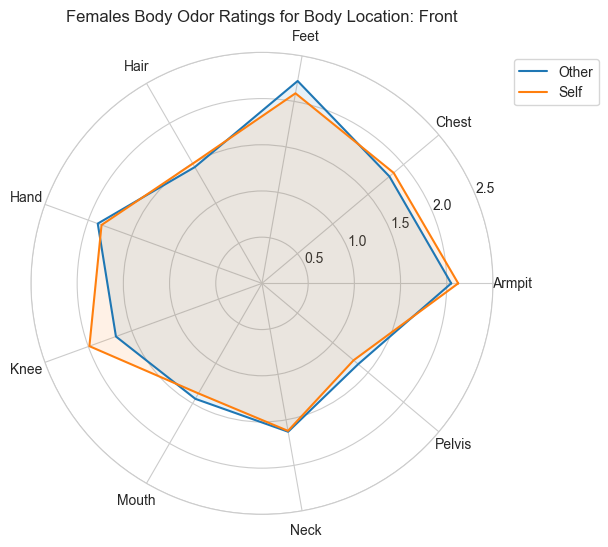

In [4]:
summary_df = (
    female.groupby(['Location', 'Type', 'Segment'])['Rating']
    .mean()
    .reset_index()
)

location = 'Front'
pivot_df = summary_df[summary_df['Location'] == location].pivot(
    index='Type',
    columns='Segment',
    values='Rating'
)
categories = list(pivot_df.columns)
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each Type
for idx, row in pivot_df.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)

ticks = [0.5, 1.0, 1.5,2.0,2.5]

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_yticks(ticks)
ax.set_title(f'Females Body Odor Ratings for Body Location: {location}')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/Radar-female-front.png', dpi=350, bbox_inches='tight')
plt.show()